# Hindcast 2019-05 Jun-Aug anomalies

This notebook contains the processing code to plot hindcast 2019-05 anomalies over the 2015-2019 record.

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

### Processing

Load fields from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
slc = {'y': slice(334, 790), 'x': slice(114, 390)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['salinity', 'nitrate', 'diatoms', 'ciliates', 'flagellates']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(6, 9):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        # Load salinity
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            data['salinity'].append(ds.vosaline.isel(deptht=0, **slc).values)
        
        # Load ecosystem variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
            for var in ['diatoms', 'ciliates', 'flagellates']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add chlorophyll fields
aggregates['chlorophyll'] = {}
variables.append('chlorophyll')
for year in years:
    aggregates['chlorophyll'][year] = sum(aggregates[var][year] for var in ['diatoms', 'ciliates', 'flagellates'])

# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

  0%|          | 0/5 [00:00<?, ?it/s]

Load HRDPS wind

In [4]:
# Load wind from pre-aggregated .nc file
HRDPS = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/HRDPS_1h_20141201_20200201_wind.nc')
time = HRDPS.time.values.astype('datetime64[s]').astype(datetime)
windmask = HRDPS.landmask.values
u, v = [HRDPS[var].values for var in ('u_wind', 'v_wind')]
wspd = np.sqrt(u**2 + v**2)

# Compiles summer averages
aggregates['wspd'] = {}
for year in years:
    index = (time > datetime(year, 6, 1)) & (time < datetime(year, 9, 1))
    aggregates['wspd'][year] = wspd[index].mean(axis=0)

# Find 5 year mean and yearly anomalies
aggregates['wspd']['mean'] = np.concatenate([aggregates['wspd'][year][None, ...] for year in years]).mean(axis=0)
for year in years: aggregates['wspd'][year] = aggregates['wspd'][year] - aggregates['wspd']['mean']

Reset some variables for plotting

In [5]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['wspd', 'salinity', 'nitrate', 'diatoms', 'chlorophyll']

***

### Plotting

Plot seasonal averages

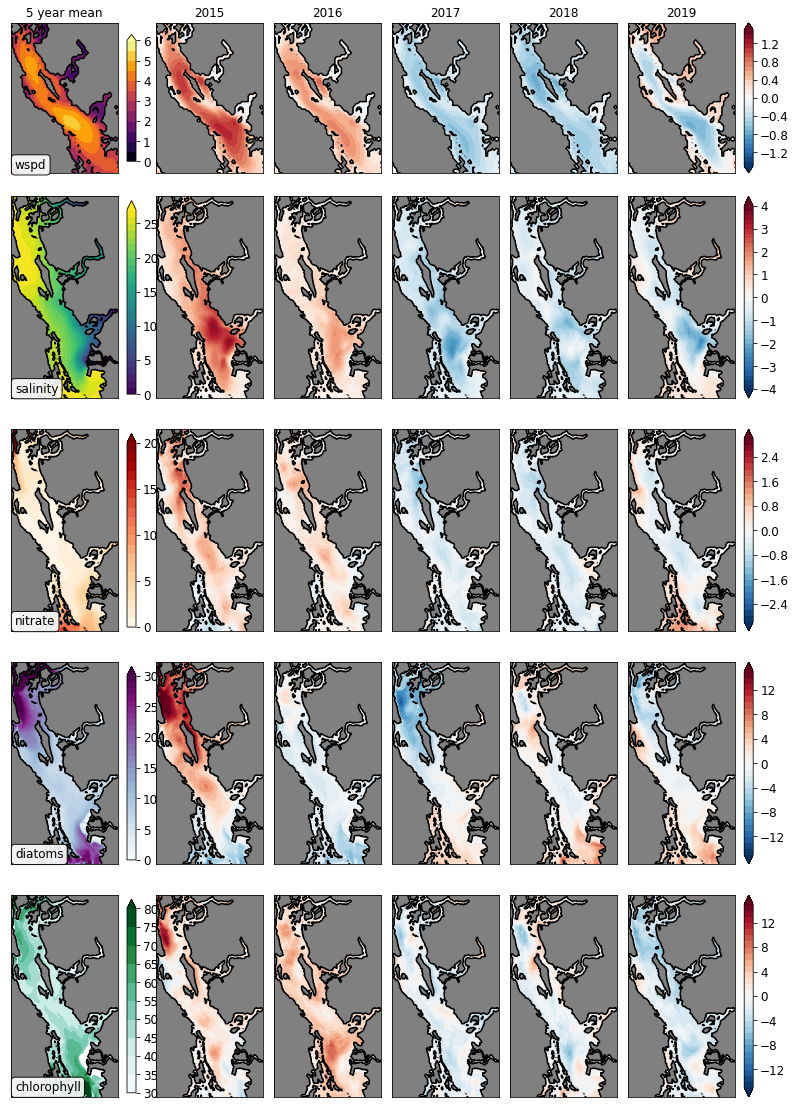

In [12]:
gridspec_kw = {'height_ratios': [0.7, 1, 1, 1, 1], 'wspace': 0.1, 'hspace': 0.05}
fig, axs = plt.subplots(5, 6, figsize=(12.5, 20), gridspec_kw=gridspec_kw)

cmaps = ['inferno', 'viridis', 'OrRd', 'BuPu', 'BuGn']
clims = [(0, 6.1, 0.5), (0, 28, 1), (0, 21, 1), (0, 30.1, 1), (30, 80.1, 5)]
dclims = [(-1.5, 1.6, 0.1), (-4, 4.1, 0.2), (-3, 3.1, 0.2), (-15, 15.1, 1), (-15, 15.1, 1)]
for row, var, cmap, clim, dclim, dcbar in zip(axs, variables, cmaps, clims, dclims, [1, 5, 5, 5, 5]):
    
    c = row[0].contourf(aggregates[var]['mean'], levels=np.arange(*clim), cmap=cmap, extend='max')
    pos = row[0].get_position()
    row[0].set_position([pos.x0-0.03, pos.y0, pos.width, pos.height])
    cax = fig.add_axes([pos.x1-0.02, pos.y0+0.01, 0.01, pos.height-0.02])
    fig.colorbar(c, cax=cax, ticks=range(0, 101, dcbar))
    row[0].text(0.04, 0.03, var, transform=row[0].transAxes, bbox={'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9})
    if var == 'wspd': row[0].set_title('5 year mean', fontsize=12)
    
    for ax, year in zip(row[1:], years):
    
        c = ax.contourf(aggregates[var][year], levels=np.arange(*dclim), cmap='RdBu_r', extend='both')
        if var == 'wspd': ax.set_title(year, fontsize=12)
    
    for ax in row:
        if var == 'wspd':
            landmask = windmask
            ax.set_xlim([5, 70])
            ax.set_ylim([30, 110])
        else:
            landmask = tmask
        ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)
    
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+0.01, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax)

***

### Other plots

Fraser flow gauge

In [7]:
# Quick load Fraser hydrograph (if needed)
Fraser = {}
data = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][1].flatten()
Fraser['date'] = np.array([
    datetime.fromordinal(int(mtime)) +
    timedelta(days=float(mtime)%1) - timedelta(days=366)
    for mtime in data['fraser'][0][0][0]
])

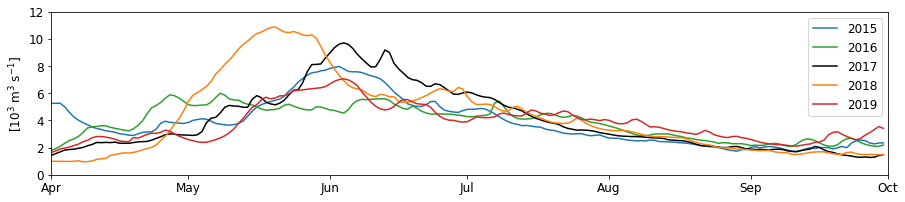

In [8]:
# Build figure layout
fig, ax = plt.subplots(figsize=(15, 3))

# Plotting properties
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]

# Plot Fraser hydrograph
for year, color in zip(range(2015, 2020), palette):
    index = np.logical_and(Fraser['date'] >= datetime(year, 4, 1), Fraser['date'] < datetime(year, 10, 1))
    x = [datetime(2020, t.month, t.day) for t in Fraser['date'][index]]
    ax.plot(x, 1e-3*Fraser['flow'][index], color=color, label=year)
ax.set_xlim([datetime(2020, 4, 1), datetime(2020, 10, 1)])
ax.set_ylim([0, 12])
ax.set_ylabel('[10$^3$ m$^3$ s$^{-1}$]')
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
ax.legend()

Southern Oscillation Index

In [9]:
df = pd.read_csv('https://www.cpc.ncep.noaa.gov/data/indices/soi', skiprows=87, index_col=0, delim_whitespace=True)
df = df[:-10]

In [10]:
date, SOI = [], []
for year in range(2005, 2020):
    for month in range(1, 13):
        index = df.index == str(year)
        date.append(datetime(year, month, 1))
        SOI.append(float(df[month_name[month][:3].upper()][index]))
date = np.array(date)
SOI = np.array(SOI)

<BarContainer object of 75 artists>

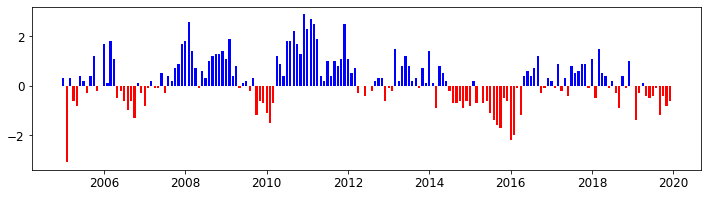

In [11]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(date[SOI>0], SOI[SOI>0], width=20, color='b')
ax.bar(date[SOI<0], SOI[SOI<0], width=20, color='r')